In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
from astropy import units as u
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
quasJ = [os.path.join('/media/lynge/Lynge-Back-up/NGC7213/NGC7213r',f) \
        for f in os.listdir('/media/lynge/Lynge-Back-up/NGC7213/NGC7213r')]

qua1_RA_WORLD = SkyCoord('22:09:16.239  -47:09:59.95', unit=(u.hourangle, u.deg)).ra.degree
qua1_DEC_WORLD = SkyCoord('22:09:16.239  -47:09:59.95', unit=(u.hourangle, u.deg)).dec.degree

print qua1_RA_WORLD

sta1_RA_WORLD = SkyCoord('22:08:51.993  -47:10:28.64', unit=(u.hourangle, u.deg)).ra.degree #UCAC3 86-422902
sta1_DEC_WORLD = SkyCoord('22:08:51.993  -47:10:28.64', unit=(u.hourangle, u.deg)).dec.degree

sta2_RA_WORLD = SkyCoord('22:08:51.908  -47:07:20.88', unit=(u.hourangle, u.deg)).ra.degree #TYC 8438-1960-1
sta2_DEC_WORLD = SkyCoord('22:08:51.908  -47:07:20.88', unit=(u.hourangle, u.deg)).dec.degree

sta3_RA_WORLD = float('nan') #SkyCoord('05:58:11.342 -38:18:29.98', unit=(u.hourangle, u.deg)).ra.degree
sta3_DEC_WORLD = float('nan') #SkyCoord('05:58:11.342 -38:18:29.98', unit=(u.hourangle, u.deg)).dec.degree

sky_RA_WORLD = SkyCoord('22:09:06 -47:09:13', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky_DEC_WORLD = SkyCoord('22:09:06 -47:09:13', unit=(u.hourangle, u.deg)).dec.degree 


MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = 8.997
MAG_HD101274_H = 8.982
MAG_HD101274_K = 8.909

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

332.3176625


In [3]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [4]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [5]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [6]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [7]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [8]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":10, 'DETECT_MINAREA':50, 'DETECT_MAXAREA':30000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [9]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 20. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 20. and \
            DECmain - 20. < out['table']['YMODEL_IMAGE'][j] < DECmain + 20.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [10]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = data2
    
    return float(header['GAIN'])*data1_2*header['EXPTIME']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['EXPTIME'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['EXPTIME']
                                                         +npix1*header['RONOISE']**2))
#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    print i
    data1, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    data2 = data1
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN -SIP"
    header['CTYPE2'] = "DEC--TAN -SIP"
    #a_sky = curve(data2,header,WCS(quasJ[i]),
    #               (sky_RA_WORLD,sky_DEC_WORLD),0.002)[0]
    #a_sky_mean = np.mean(a_sky)
    #for j in range(len(np.shape(data[0]))):
    #    for k in range(len(np.shape(data[0]))):
    #        if data[j,k] != 0:
    #            data[j,k] = float(data[j,k]) - a_sky_mean
    #header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data1,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [11]:
a = np.array([[0,2],
              [3,4]])
b = np.mean(np.array([[1,2,3],
                      [2,2,2],
                      [1,1,1]]))

a = a.astype(float)
mask = a != 0.
a[mask] = a[mask] - float(b)
print a

[[ 0.          0.33333333]
 [ 1.33333333  2.33333333]]


In [12]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),5))
    SNR_array = np.zeros((len(quas),8))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['EXPTIME']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['EXPTIME']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['EXPTIME']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['EXPTIME']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['EXPTIME']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = a_AGN
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN, a2, a3
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date

In [13]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1 = SEXAGNflux(quasJ,0.001)

Frame nr.  0 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016119BRs093.fits


/home/lynge/anaconda2/lib/python2.7/site-packages/pyfits/hdu/image.py:515: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.
  warnings.warn(msg, VerifyWarning)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
No handlers could be found for logger "sewpy.sewpy"
/home/lynge/.local/lib/python2.7/site-packages/astropy/wcs/wcs.py:1669: RuntimeWarning: All-NaN slice encountered
  while (np.nanmax(dn) >= tol2 and k < maxiter):


6372.54333333 4998.58666667 nan
Frame nr.  1 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016119BRs094.fits
7262.28666667 5581.11666667 nan
Frame nr.  2 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016119BRs095.fits
8026.20333333 6216.07 nan
Frame nr.  3 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016122BRs055.fits
13608.885 10901.2483333 nan
Frame nr.  4 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016122BRs056.fits
13709.5266667 11039.68 nan
Frame nr.  5 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016122BRs057.fits
13803.315 11112.685 nan
Frame nr.  6 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016127BRs080.fits
nan nan nan
Frame nr.  7 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016127BRs081.fits
nan nan nan
Frame nr.  8 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016127BRs082.fits
nan nan nan
Frame nr.  9 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016131BRs046.fits
nan nan nan
Frame nr.  10 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016131BRs0

9446.17666667 7233.01333333 nan
Frame nr.  77 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016360BRs033.fits
9499.11833333 7276.39833333 nan
Frame nr.  78 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016360BRs034.fits
9506.95333333 7266.42833333 nan
Frame nr.  79 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016363BRs028.fits
9722.10666667 7611.08333333 4656.365
Frame nr.  80 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016363BRs029.fits
9697.72166667 7608.07 4648.70166667
Frame nr.  81 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016363BRs030.fits
9626.785 7475.13333333 4564.10166667
Frame nr.  82 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017102BRs065.fits
nan nan nan
Frame nr.  83 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017102BRs066.fits
nan nan nan
Frame nr.  84 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017102BRs067.fits
nan nan nan
Frame nr.  85 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017118BRs071.fits
2770.525 1817.44 nan
Frame nr.  86 /me

13378.6366667 10763.8433333 1167.85666667
Frame nr.  152 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016301BRs027.fits
13181.3233333 10572.3416667 1661.934
Frame nr.  153 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016305BRs104.fits
10398.2183333 7892.21333333 nan
Frame nr.  154 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016305BRs105.fits
10364.5633333 7932.93166667 nan
Frame nr.  155 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016305BRs106.fits
10332.4166667 7851.175 nan
Frame nr.  156 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016311BRs039.fits
12726.9183333 10145.4416667 1896.77833333
Frame nr.  157 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016311BRs040.fits
12701.52 10192.5 3347.49333333
Frame nr.  158 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016311BRs041.fits
12711.785 10197.8433333 4585.17
Frame nr.  159 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016314BRs065.fits
11727.4366667 9004.315 nan
Frame nr.  160 /media/lynge/Lynge-Back-up/NGC7213/

10278.8033333 nan nan
Frame nr.  227 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017310BRs108.fits
9967.56166667 nan nan
Frame nr.  228 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017313BRs070.fits
10637.505 nan nan
Frame nr.  229 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017313BRs071.fits
10651.5733333 nan nan
Frame nr.  230 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017313BRs072.fits
10534.62 nan nan
Frame nr.  231 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017316BRs088.fits
10063.6966667 nan nan
Frame nr.  232 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017316BRs089.fits
10016.2616667 nan nan
Frame nr.  233 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2017316BRs090.fits
9990.44 nan nan
Frame nr.  234 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016168BRs128.fits
14890.0016667 11620.3983333 7350.055
Frame nr.  235 /media/lynge/Lynge-Back-up/NGC7213/NGC7213r/IMG2016172BRs139.fits
14922.7716667 11554.0933333 7302.88166667
Frame nr.  236 /media/lynge/Lyn

In [14]:
print np.nanmean(comp_array[:,4]), np.nanstd(comp_array[:,4])
print np.nanmean(comp_array[:,1]), np.nanstd(comp_array[:,1])
print np.nanmean(comp_array[:,2]), np.nanstd(comp_array[:,2])
comp_array_mod = np.copy(comp_array)
comp_array_mod[comp_array[:,4] < np.nanmean(comp_array[:,4]) - 0.5*np.nanstd(comp_array[:,4]),1:5] = float('nan')


11694.4175299 2930.37392555
1.42037398722 2.09270935365
3.82488031125 5.38561560171


In [15]:
print np.nanmean(comp_array[:,4])
print np.nanmean(comp_array_mod[:,4])

11694.4175299
13088.6376302


In [16]:
#print comp_array_mod
comp_array_mod_2 = np.zeros((len(comp_array_mod[:,0]),13))
#comp_array_mod_2[0,0] = comp_array_mod[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array_mod)):
    if comp_array_mod[i,0] != comp_array_mod_2[tjek,0]:
        comp_array_mod_2[tjek,0] = comp_array_mod[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array_mod)):
            if comp_array_mod_2[tjek,0] == comp_array_mod[j,0]:
                com1.append(comp_array_mod[j,1])
                com2.append(comp_array_mod[j,2])
                com3.append(comp_array_mod[j,3])
        comp_array_mod_2[tjek,1] = np.mean(com1)
        comp_array_mod_2[tjek,2] = np.std(com1)
        if comp_array_mod_2[tjek,2]/float(comp_array_mod_2[tjek,1]) > acceptance or float(comp_array_mod_2[tjek,1]) < 0:
            comp_array_mod_2[tjek,1] = float('nan')
            comp_array_mod_2[tjek,2] = float('nan')
        comp_array_mod_2[tjek,3] = np.mean(com2)
        comp_array_mod_2[tjek,4] = np.std(com2)
        if comp_array_mod_2[tjek,4]/float(comp_array_mod_2[tjek,3]) > acceptance or float(comp_array_mod_2[tjek,3]) < 0:
            comp_array_mod_2[tjek,3] = float('nan')
            comp_array_mod_2[tjek,4] = float('nan')
        comp_array_mod_2[tjek,5] = np.mean(com3)
        comp_array_mod_2[tjek,6] = np.std(com3)
        if comp_array_mod_2[tjek,6]/float(comp_array_mod_2[tjek,5]) > acceptance or float(comp_array_mod_2[tjek,5]) < 0:
            comp_array_mod_2[tjek,5] = float('nan')
            comp_array_mod_2[tjek,6] = float('nan')
        tjek = tjek + 1



In [17]:
#print comp_array
comp_array_2 = np.zeros((len(comp_array[:,0]),13))
#comp_array_2[0,0] = comp_array[0,0]
tjek = 0
acceptance = 0.01

for i in range(len(comp_array)):
    if comp_array[i,0] != comp_array_2[tjek,0]:
        comp_array_2[tjek,0] = comp_array[i,0]
        com1 = []
        com2 = []
        com3 = []
        for j in range(len(comp_array)):
            if comp_array_2[tjek,0] == comp_array[j,0]:
                com1.append(comp_array[j,1])
                com2.append(comp_array[j,2])
                com3.append(comp_array[j,3])
        comp_array_2[tjek,1] = np.mean(com1)
        comp_array_2[tjek,2] = np.std(com1)
        if comp_array_2[tjek,2]/float(comp_array_2[tjek,1]) > acceptance or float(comp_array_2[tjek,1]) < 0:
            comp_array_2[tjek,1] = float('nan')
            comp_array_2[tjek,2] = float('nan')
        comp_array_2[tjek,3] = np.mean(com2)
        comp_array_2[tjek,4] = np.std(com2)
        if comp_array_2[tjek,4]/float(comp_array_2[tjek,3]) > acceptance or float(comp_array_2[tjek,3]) < 0:
            comp_array_2[tjek,3] = float('nan')
            comp_array_2[tjek,4] = float('nan')
        comp_array_2[tjek,5] = np.mean(com3)
        comp_array_2[tjek,6] = np.std(com3)
        if comp_array_2[tjek,6]/float(comp_array_2[tjek,5]) > acceptance or float(comp_array_2[tjek,5]) < 0:
            comp_array_2[tjek,5] = float('nan')
            comp_array_2[tjek,6] = float('nan')
        tjek = tjek + 1

np.savetxt('NGC7213-r',comp_array_mod)

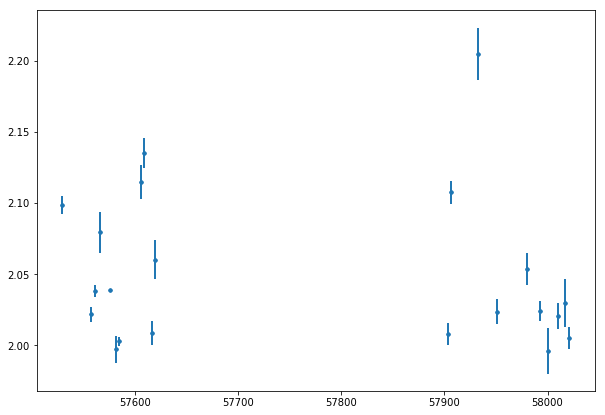

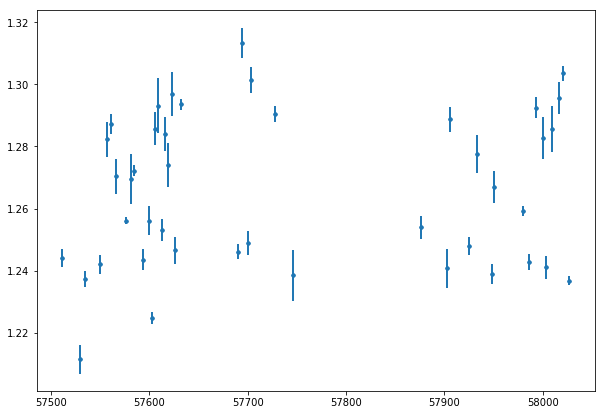

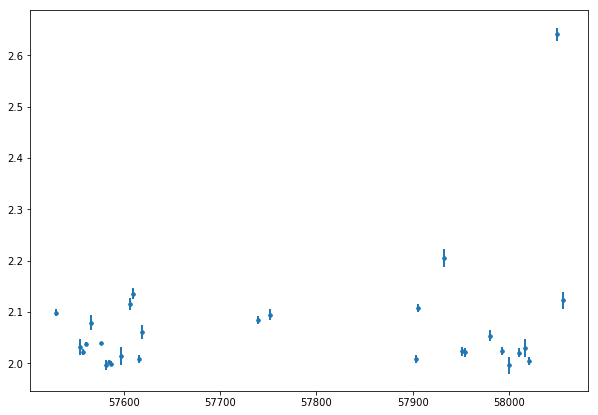

In [19]:
plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,3],yerr=comp_array_mod_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_mod_2[:,0],comp_array_mod_2[:,1],yerr=comp_array_mod_2[:,2],fmt='.')
#plt.ylim([1.2,1.8])
plt.show()

plt.figure(figsize=(10,7))
plt.errorbar(comp_array_2[:,0],comp_array_2[:,3],yerr=comp_array_2[:,4],fmt='.')
#plt.ylim([0.02,0.07])
plt.show()
